#### Importing Data from yfinance library

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [40]:
ibm = yf.download("IBM")
ibm.shape

[*********************100%***********************]  1 of 1 completed


(14929, 6)

#### Inspecting Data

In [20]:
ibm.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500


<AxesSubplot:xlabel='Date'>

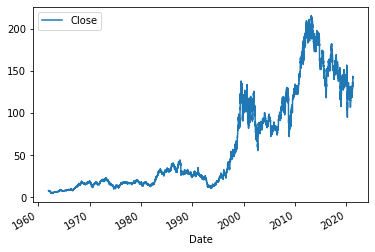

In [10]:
ibm.plot(x="Date", y="Close")

In [12]:
ibm.sort_values(by = "Date", ascending = False)

,Date,Open,High,Low,Close,Adj Close,Volume
14928,2021-04-22,143.699997,144.740005,141.238205,141.330002,141.330002,4897242
14927,2021-04-21,138.059998,143.729996,137.710007,143.550003,143.550003,11905200
14926,2021-04-20,137.070007,139.770004,136.699997,138.160004,138.160004,15480600
14925,2021-04-19,133.600006,133.820007,132.580002,133.119995,133.119995,8198600
14924,2021-04-16,133.000000,134.100006,132.949997,133.589996,133.589996,5290900
...,...,...,...,...,...,...,...
4,1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500
3,1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500
2,1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500
1,1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500


In [41]:
ibm.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

#### SPLITTING DATA INTO TRAIN & TEST SETS

I am going to split data into train & test sets by sklearn's `train_test_split` <br>
**train_test_split** is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model. [*](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/#:~:text=The%20train%2Dtest%20split%20procedure,used%20to%20train%20the%20model.)<br>
It splits arrays or matrices into random train and test subsets[*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ibm.drop(columns='Close'), ibm["Close"], test_size = 0.3,
                                                   random_state = 123)

#### Untuned Decision Tree Regressor Base Model

**By default, XGBoost uses trees as base learners**, so I don't have to specify that I want to use trees here with `booster="gbtree"`.

In [71]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
xgr = xgb.XGBRegressor(objective = "reg:linear", n_estimators = 10, seed = 123)
# n_estimators = 10 -> setting 10 boosting rounds
# seed is random seed to ensure getting the same results when you run the same code multiple times. seed = 123 is for simlicity
xgr.fit(X_train, y_train)
y_pred = xgr.predict(X_test)
RMSE = MSE(y_pred, y_test)**(1/2)
print("R.M.S.E for Untuned Decision Tree Regression Base Model is: ", RMSE)

[23:01:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
R.M.S.E for Untuned Decision Tree Regression Base Model is:  2.496089317463909


#### Untuned Linear Regression Model

In [73]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
xgr = xgb.XGBRegressor(objective = "reg:linear", booster = "gblinear",n_estimators = 10, seed = 123)
xgr.fit(X_train, y_train)
y_pred = xgr.predict(X_test)
RMSE = MSE(y_pred, y_test)**(1/2)
print("R.M.S.E for Untuned Linear Regression Base Model is: ", RMSE)

[23:01:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
R.M.S.E for Untuned Linear Regression Base Model is:  5.555844284032233


* Untuned Decision Tree Regressor Base Model's R.M.S.E. Score(2.49) is lower than Untuned Linear Regression Model's R.M.S.E. Score(5.55). As lower R.M.S.E. Score is better in R.M.S.E., in our case; Decision Tree Regressor is more convinient base for XGBoost.  

#### Hyperparameter Tuning with Grid Search C.V.

**GridSearchCV** is a library function that is a member of sklearn's model_selection package. It helps to loop through predefined hyperparameters and fit your estimator (model) on your training set. So, in the end, you can select the best parameters from the listed hyperparameters [source](https://towardsdatascience.com/grid-search-for-hyperparameter-tuning-9f63945e8fec)

In [57]:
from sklearn.model_selection import GridSearchCV
gbm_param_grid = {"n_estimators" : [0.1,1,10,100],
                 "seed" : [123, 42, 236, 84]}
gbm = xgb.XGBRegressor()
grid_mse = GridSearchCV(estimator = gbm,
                        param_grid = gbm_param_grid, 
                        scoring = "neg_mean_squared_error", 
                        cv = 4, 
                       verbose = 1)
grid_mse.fit(X_train, y_train)
print("Best params are: ", grid_mse.best_params_)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


C:\Users\talfi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\talfi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\talfi\anaconda3\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\talfi\anaconda3\lib\site-packages\xgboost\sklearn.py", line 597, in fit
    self._Booster = train(params, train_dmatrix,
  File "C:\Users\talfi\anaconda3\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\talfi\anaconda3\lib\site-packages\xgboost\training.py", line 96, in _train_internal
    for i in range(start_iteration, num_boost_round):
TypeError: 'float' object cannot be in

C:\Users\talfi\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [            nan             nan             nan             nan
 -3.46110950e+03 -3.46110950e+03 -3.46110950e+03 -3.46110950e+03
 -6.64429323e+00 -6.64429323e+00 -6.64429323e+00 -6.64429323e+00
 -3.91613378e-01 -3.91613378e-01 -3.91613378e-01 -3.91613378e-01]
  warnings.warn(


Best params are:  {'n_estimators': 100, 'seed': 123}


Let's set the hyperparameters accordingly and see if there is any improvement in R.M.S.E. Score

#### Tuned Decision Tree Regressor Base Model

In [74]:
xgr = xgb.XGBRegressor(objective = "reg:linear",  n_estimators = 100, seed = 123)
xgr.fit(X_train, y_train)
y_pred = xgr.predict(X_test)
RMSE = MSE(y_pred, y_test)**(1/2)
print("R.M.S.E for Tuned Decision Tree Regressor Base model is: ", RMSE)

[23:02:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
R.M.S.E for Tuned Decision Tree Regressor Base model is:  0.5735329172129329


From 2.49 to 0.57; 4,36 times better than untuned version!  

#### Tuned Linear Regression Base Model

In [75]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
xgr = xgb.XGBRegressor(objective = "reg:linear", booster = "gblinear",n_estimators = 100, seed = 123)
xgr.fit(X_train, y_train)
y_pred = xgr.predict(X_test)
RMSE = MSE(y_pred, y_test)**(1/2)
print("R.M.S.E for Tuned Linear Regression Base model is: ", RMSE)

[23:03:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
R.M.S.E for Tuned Linear Regression Base model is:  2.6003958135102794


5.55 to 2.60 . 2.13 times better than untuned version!

* Tuned Decision Tree Regressor Base Model's R.M.S.E. Score(0.57) is lower than Tuned Linear Regression Model's R.M.S.E. Score(2.60). As lower R.M.S.E. Score is better in R.M.S.E., in our case; Decision Tree Regressor is more convinient base for XGBoost.  